In [ ]:
import pandas as pd
import numpy as np
from pylab import plt, mpl
from scipy import stats
from google.colab import drive

drive = drive.mount('/content/drive')
dir = '/content/drive/MyDrive/EL/'

plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 1000
mpl.rcParams['font.family'] = 'serif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv(f'{dir}AB_NYC_2019.csv')
data.set_index('id', drop=True, inplace=True)
data.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
id,,,,,,,,,,,,,,,
2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
label = 'price'
features = list(data.columns)
features.remove(label)

In [ ]:
null_columns = data.isnull().sum().to_dict()
null_columns

{'name': 16,
 'host_id': 0,
 'host_name': 21,
 'neighbourhood_group': 0,
 'neighbourhood': 0,
 'latitude': 0,
 'longitude': 0,
 'room_type': 0,
 'price': 0,
 'minimum_nights': 0,
 'number_of_reviews': 0,
 'last_review': 10052,
 'reviews_per_month': 10052,
 'calculated_host_listings_count': 0,
 'availability_365': 0}

In [ ]:
"""
Assert that the NaN values for last_review and reviews_per_month columns have the same ID
It is logical: if a rent never had a review i.e last_review = NaN then reviews_per_month is NaN too
Therefore NaN will be replaced by 0, and only one column (reviews_per_month) will be kept
"""
np.any(data.loc[data['last_review'].isnull(), 'last_review'].index == data.loc[data['reviews_per_month'].isnull(), 'reviews_per_month'].index)

True

In [ ]:
features.remove('last_review') #not important feature
features.remove('name') #no predictive power as two different rent can have same name
features.remove('host_name') #already have host_id
features

['host_id',
 'neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

In [ ]:
"""
Filling NaN to 0, representing listings with not yet reviews
"""
data['reviews_per_month'].fillna(0, inplace=True) 

In [ ]:
"""
Categorical and Numerical features
"""
features_type = data[features].dtypes.to_dict()
features_value = [name for name, obj in features_type.items() if not obj.type==np.object_]
features_cat = [name for name, obj in features_type.items() if obj.type==np.object_]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
"""
Min max scaler between [0,1]
"""
def min_max_scale(X: np.ndarray, scaler, env):
    if len(X.shape)==1:
        X = X.reshape(-1, 1)
    if env == 'train':
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    return X, scaler

def undo_min_max_scale(normalized, scaler):
    X = scaler.inverse_transform(normalized)
    return X

"""
Log + Min max scaler between [0,1]
"""
def log_min_max_scale(y, scaler, env):
    y = np.log(y)
    y, scaler_y = min_max_scale(y, scaler, env)
    return y.squeeze(), scaler_y

def undo_log_min_max_scale(y_log_norm, scaler):
    if len(y_log_norm.shape)==1:
        y_log_norm = y_log_norm.reshape(-1, 1)
    y_log = undo_min_max_scale(y_log_norm, scaler).squeeze()
    return np.exp(y_log)

Label

price summary statisctics: 
count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

outsiders i.e. most expensive prices: 
id
22436899    10000
7003697     10000
13894339    10000
9528920      9999
4737930      9999
            ...  
31088862      890
32065845      890
909859        890
6758849       888
34253279      875
Name: price, Length: 388, dtype: int64


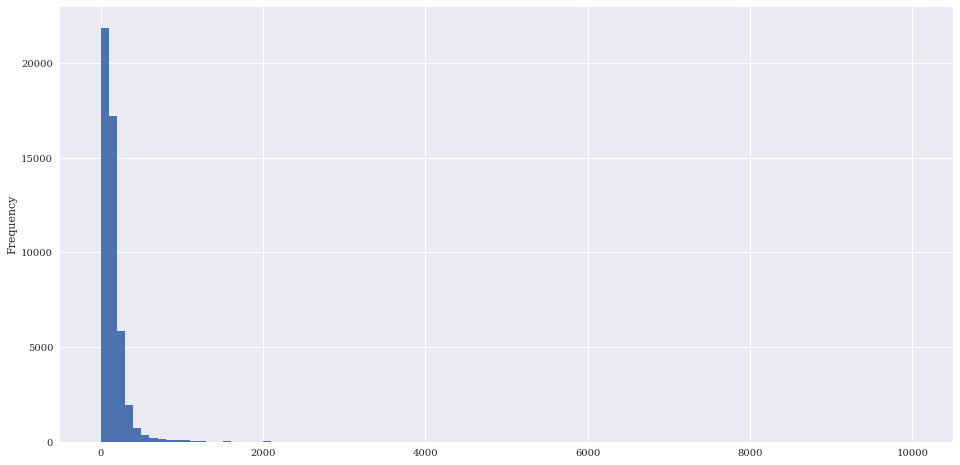

In [ ]:
print('price summary statisctics: ')
print(data[label].describe())
print("\noutsiders i.e. most expensive prices: ")
print(data[(np.abs(stats.zscore(data[label])) > 3)][label].sort_values(ascending=False))
data[label].plot.hist(bins=100, figsize=(16,8))
#right skew and extrem values

In [ ]:
"""
Some rents have a price of 0 --> they have to be deleted
"""
index_to_drop = data[data[label]==0].index 
data.drop(index_to_drop, axis=0, inplace=True)

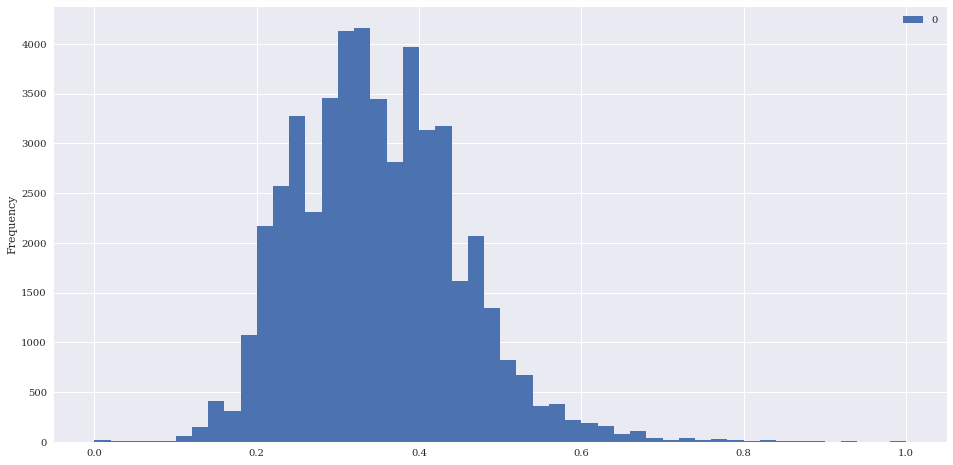

In [ ]:
y, _ = log_min_max_scale(data[label].values, MinMaxScaler(), 'train')
pd.DataFrame(y).plot.hist(bins=50, figsize=(16,8))

Categorical features

In [ ]:
data[features_cat].describe()

,neighbourhood_group,neighbourhood,room_type
count,48884,48884,48884
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21660,3919,25407


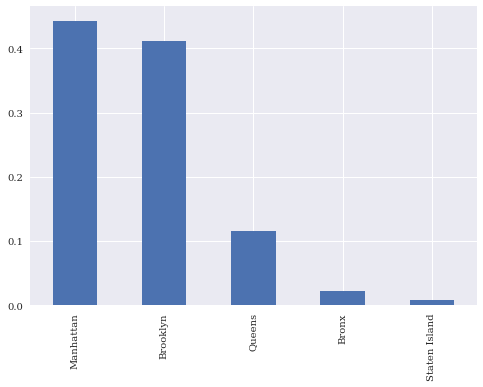

In [ ]:
data['neighbourhood_group'].value_counts(normalize=True).plot.bar()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


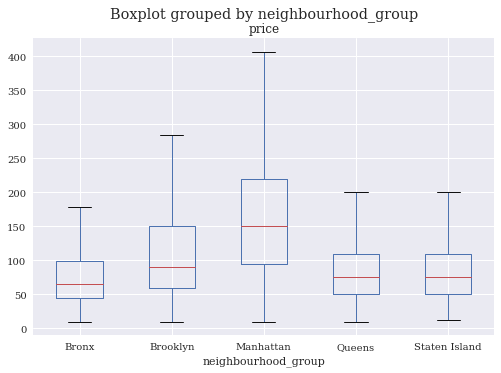

In [ ]:
data.boxplot(column=label,by='neighbourhood_group',showfliers=False)

There is too much neighbourhoods 221, have to remove outliers
Keep only the most important neighbourhoods representing at least 95.0% of listings
Reduce to 87


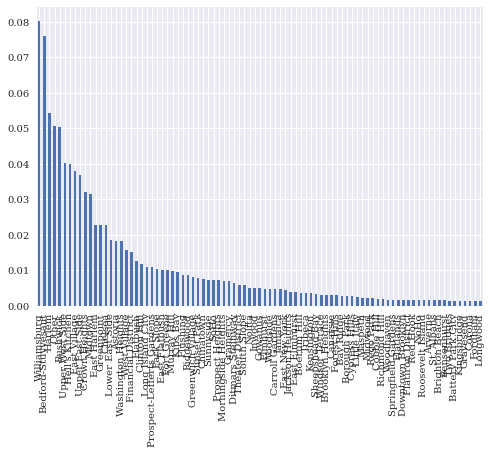

In [ ]:
neigh = data['neighbourhood']
print(f'There is too much neighbourhoods {neigh.nunique()}, have to remove outliers')
neighb_counts_norm = neigh.value_counts(normalize=True)
thrshold = 0.95
dim = np.searchsorted(neighb_counts_norm.cumsum()/neighb_counts_norm.sum(),thrshold)
neighb_to_keep = neighb_counts_norm[:dim].index
print(f'Keep only the most important neighbourhoods representing at least {thrshold*100}% of listings')
neighb_counts_norm[:dim]

def clean_neighb(x, neighb_to_keep):
    if x not in neighb_to_keep:
        return 'Other'
    else:
        return x

data['neighbourhood'] = data['neighbourhood'].apply(lambda x: clean_neighb(x, neighb_to_keep))
data['neighbourhood'].value_counts(normalize=True).plot.bar()
print('Reduce to', data["neighbourhood"].nunique())

In [ ]:
print("Top 10 expensive neighbourhood")
print(data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)[:10])
print("Top 10 cheapest neighbourhood")
print(data.groupby('neighbourhood')['price'].mean().sort_values(ascending=False)[-10:])

Top 10 expensive neighbourhood
neighbourhood
Tribeca              490.638418
Battery Park City    367.557143
Flatiron District    341.925000
NoHo                 295.717949
SoHo                 287.103352
Midtown              282.719094
West Village         267.682292
Greenwich Village    263.405612
Chelsea              249.738544
Theater District     248.013889
Name: price, dtype: float64
Top 10 cheapest neighbourhood
neighbourhood
Elmhurst        80.459916
Midwood         80.339450
Gravesend       79.014706
Kingsbridge     77.928571
Ridgewood       77.184397
Bensonhurst     75.786667
Fordham         69.444444
Woodhaven       67.170455
Borough Park    63.066176
Corona          59.171875
Name: price, dtype: float64


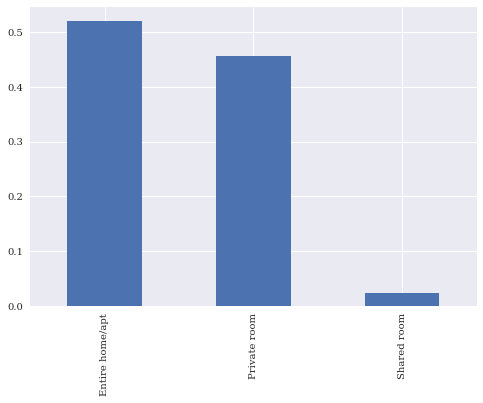

In [ ]:
data['room_type'].value_counts(normalize=True).plot.bar()

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


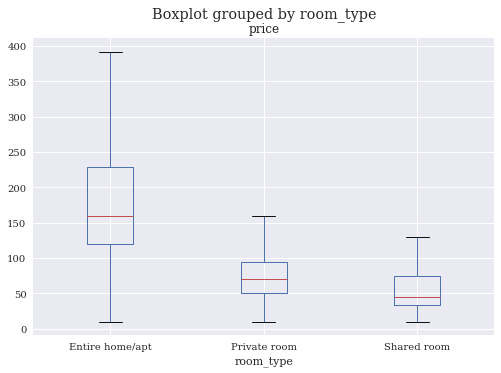

In [ ]:
data.boxplot(column=label,by='room_type',showfliers=False)

Numerical features

In [ ]:
data[features_value].describe()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.888400e+04,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000,48884.000000
mean,6.762203e+07,40.728953,-73.952176,7.029887,23.271991,1.090800,7.144628,112.779498
std,7.861666e+07,0.054532,0.046159,20.512224,44.551331,1.597213,32.956185,131.627271
min,2.438000e+03,40.499790,-74.244420,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.817310e+06,40.690100,-73.983080,1.000000,1.000000,0.040000,1.000000,0.000000
50%,3.079257e+07,40.723080,-73.955685,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.074344e+08,40.763120,-73.936290,5.000000,24.000000,1.580000,2.000000,227.000000
max,2.743213e+08,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80a4d136a0>,
      dtype=object)

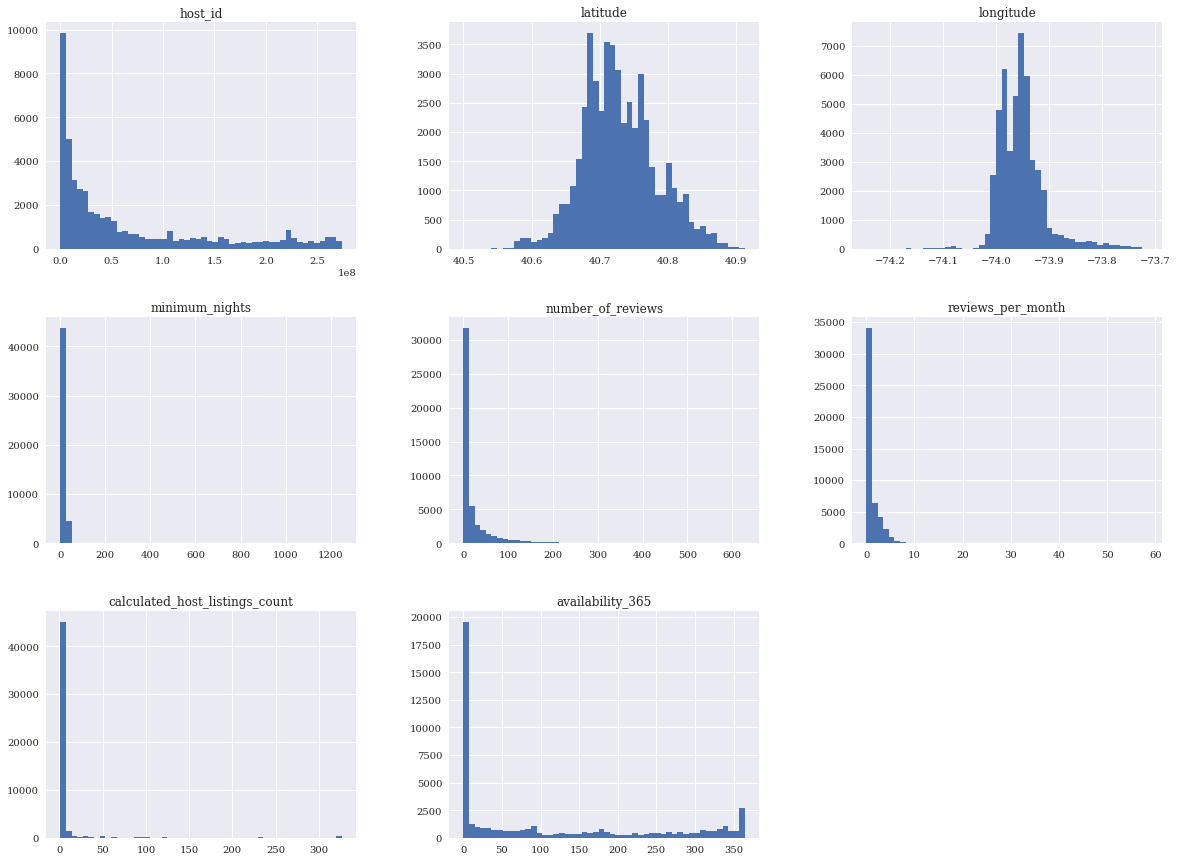

In [ ]:
data[features_value].hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f80a4b94c40>,
      dtype=object)

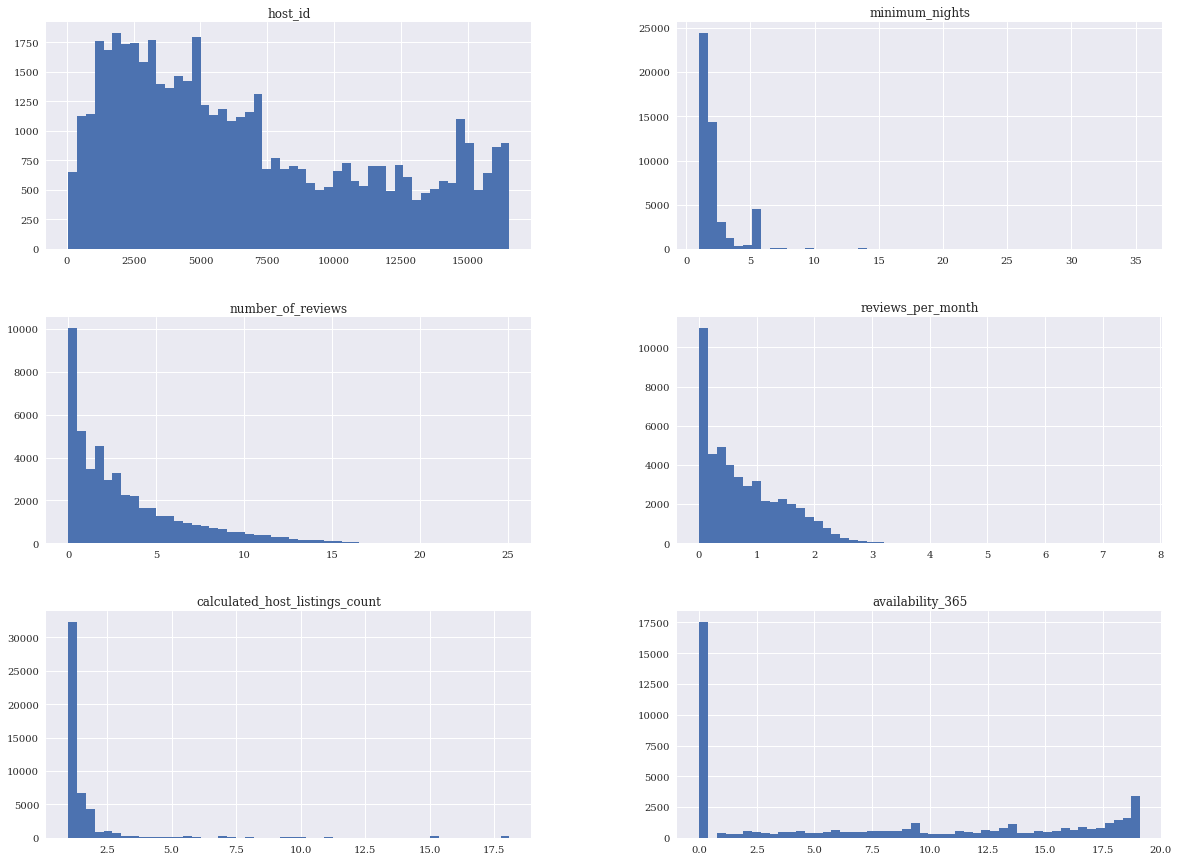

In [ ]:
skewed_features = features_value
skewed_features.remove('latitude')
skewed_features.remove('longitude')

def unskew(X):
    return X**(1/2)

(unskew(data[skewed_features])).hist(bins=50, figsize=(20,15))

In [ ]:
"""
Correlation between label and numerical features
"""
data[features_value+[label]].corr().loc[label].sort_values(ascending=False)

price                             1.000000
availability_365                  0.081847
calculated_host_listings_count    0.057462
minimum_nights                    0.042805
host_id                           0.015294
number_of_reviews                -0.047926
reviews_per_month                -0.050531
Name: price, dtype: float64

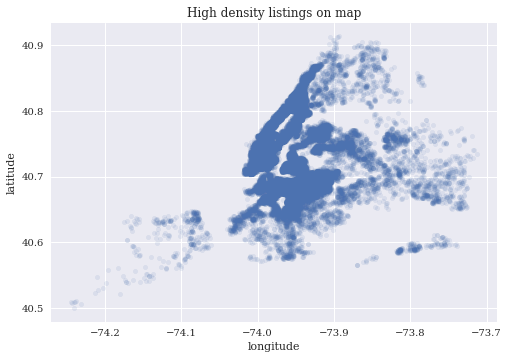

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, title='High density listings on map')

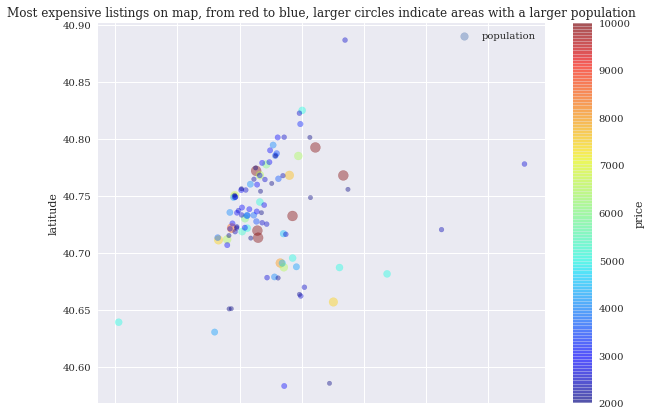

In [ ]:
most_expensive_price = data.sort_values(by=label, ascending=False)[:100]
most_expensive_price.plot(kind="scatter", x="longitude", y="latitude", s=most_expensive_price['price']/100, alpha=0.4,
 c='price', label="population", figsize=(10,7), cmap=plt.get_cmap("jet"), colorbar=True,
 title='Most expensive listings on map, from red to blue, larger circles indicate areas with a larger population'
)


In [ ]:
#for feature in features_value:
#  data.plot.scatter(x=feature, y=label)

Define training, validation and testing set

In [ ]:
from sklearn.model_selection import train_test_split

def form_norm_set(X, y, skewed_features, scaler_X, scaler_y, env):
    X[skewed_features] = unskew(X[skewed_features])
    normalized_X, scaler_X = min_max_scale(X, scaler_X, env)
    normalized_y, scaler_y = log_min_max_scale(y, scaler_y, env)
    return normalized_X, normalized_y, scaler_X, scaler_y

y = data[label]
X = data[features_value].join(pd.get_dummies(data[features_cat]))
features = list(X.columns)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.3, shuffle=True)
#X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, random_state=42, test_size=0.5, shuffle=True)

X_train, y_train, scaler_X, scaler_y = form_norm_set(X_train, y_train.values, skewed_features, MinMaxScaler(), MinMaxScaler(), 'train')
X_test, y_test, scaler_X, scaler_y = form_norm_set(X_val, y_val.values, skewed_features, scaler_X, scaler_y, 'test')

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import probplot

from yellowbrick.draw import manual_legend
from yellowbrick.style.palettes import LINE_COLOR
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.regressor.base import RegressionScoreVisualizer

from sklearn.metrics import r2_score
from yellowbrick.bestfit import draw_best_fit, draw_identity_line

def unscale_ys(y_true, y_scaler, y_pred):
    y_true = undo_log_min_max_scale(y_true, y_scaler)
    y_pred = undo_log_min_max_scale(y_pred, y_scaler)
    return y_true, y_pred

def rmse(y_true, y_pred):
    """
    put more weight on rare large errors
    """
    return np.sqrt(np.sum((y_pred - y_true) ** 2) / len(y_true))

class ResidualsPlot(RegressionScoreVisualizer):


    def __init__(
        self,
        model=None,
        ax=None,
        hist=True,
        qqplot=False,
        train_alpha=0.75,
        test_alpha=0.75,
    ):

        super(ResidualsPlot, self).__init__(
                model,
                ax=ax,
                is_fitted=False)

        # TODO: allow more scatter plot arguments for train and test points
        # See #475 (RE: ScatterPlotMixin)
        self.colors = {
            "train_point": "b",
            "test_point": "g",
            "line": LINE_COLOR,
        }

        self.hist = hist
        if self.hist not in {True, "density", "frequency", None, False}:
            raise YellowbrickValueError(
                "'{}' is an invalid argument for hist, use None, True, "
                "False, 'density', or 'frequency'".format(hist)
            )

        self.qqplot = qqplot
        if self.qqplot not in {True, False}:
            raise YellowbrickValueError(
                "'{}' is an invalid argument for qqplot, use True, "
                " or False".format(hist)
            )

        if self.hist in {True, "density", "frequency"} and self.qqplot in {True}:
            raise YellowbrickValueError(
                "Set either hist or qqplot to False, can not plot "
                "both of them simultaneously."
            )

        if self.hist in {True, "density", "frequency"}:
            self.hax = self.compute_hax() # If hist is True, test the version availability

        if self.qqplot in {True}:
            self.qqax = self.compute_qqax()# If qqplot is True, test the version availability

        # Store labels and colors for the legend ordered by call
        self._labels, self._colors = [], []

        self.alphas = {"train_point": train_alpha, "test_point": test_alpha}

    def compute_hax(self):
        """
        Returns the histogram axes, creating it only on demand.
        """
        if make_axes_locatable is None:
            raise YellowbrickValueError(
                (
                    "residuals histogram requires matplotlib 2.0.2 or greater "
                    "please upgrade matplotlib or set hist=False on the visualizer"
                )
            )

        divider = make_axes_locatable(self.ax)

        hax = divider.append_axes("right", size=1, pad=0.1, sharey=self.ax)
        hax.yaxis.tick_right()
        hax.grid(False, axis="x")

        return hax

    def compute_qqax(self):
        """
        Returns the Q-Q plot axes, creating it only on demand.
        """
        if make_axes_locatable is None:
            raise YellowbrickValueError(
                (
                    "residuals histogram requires matplotlib 2.0.2 or greater "
                    "please upgrade matplotlib or set qqplot=False on the visualizer"
                )
            )

        divider = make_axes_locatable(self.ax)

        qqax = divider.append_axes("right", size=2, pad=0.25, sharey=self.ax)
        qqax.yaxis.tick_right()

        return qqax

    def score(self, y_true, y_range, y_pred, train=False):
        # Do not call super in order to differentiate train and test scores.
        y_true, y_pred = unscale_ys(y_true, y_range, y_pred)
        score = rmse(y_true, y_pred)
        if train:
            self.train_score_ = score
        else:
            self.test_score_ = score
        residuals = y_pred - y_true
        self.draw(y_pred, residuals, train=train)
        return score

    def draw(self, y_pred, residuals, train=False):
        if train:
            color = self.colors["train_point"]
            label = "Train $RMSE = {:0.3f}$".format(self.train_score_)
            alpha = self.alphas["train_point"]
        else:
            color = self.colors["test_point"]
            label = "Test $RMSE = {:0.3f}$".format(self.test_score_)
            alpha = self.alphas["test_point"]

        # Update the legend information
        self._labels.append(label)
        self._colors.append(color)

        # Draw the residuals scatter plot
        self.ax.scatter(y_pred, residuals, c=color, alpha=alpha, label=label)

        # Add residuals histogram
        if self.hist in {True, "frequency"}:
            self.hax.hist(residuals, bins=50, orientation="horizontal", color=color)
        elif self.hist == "density":
            self.hax.hist(
                residuals, bins=50, orientation="horizontal", density=True, color=color
            )

        # Add residuals histogram
        if self.qqplot in {True}:
            osm, osr = probplot(residuals, dist="norm", fit=False)

            self.qqax.scatter(osm, osr, c=color, alpha=alpha, label=label)

        # Ensure the current axes is always the main residuals axes
        plt.sca(self.ax)
        return self.ax

    def finalize(self):
        """
        Prepares the plot for rendering by adding a title, legend, and axis labels.
        Also draws a line at the zero residuals to show the baseline.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        Notes
        -----
        Generally this method is called from show and not directly by the user.
        """
        # Add the title to the plot
        self.set_title("Residuals for {} Model".format(self.name))

        # Set the legend with full opacity patches using manual legend
        manual_legend(self, self._labels, self._colors, loc="best", frameon=True)

        # Create a full line across the figure at zero error.
        self.ax.axhline(y=0, c=self.colors["line"])

        # Set the axes labels
        self.ax.set_ylabel("Residuals")
        self.ax.set_xlabel("Predicted Value")

        # Finalize the histogram axes
        if self.hist:
            self.hax.axhline(y=0, c=self.colors["line"])
            self.hax.set_xlabel("Distribution")

        # Finalize the histogram axes
        if self.qqplot:
            self.qqax.set_title("Q-Q plot")
            self.qqax.set_xlabel("Theoretical quantiles")
            self.qqax.set_ylabel("Observed quantiles")

class PredictionError(RegressionScoreVisualizer):

    def __init__(
        self,
        model=None,
        ax=None,
        shared_limits=True,
        bestfit=True,
        identity=True,
        alpha=0.75,
    ):

        # Initialize the visualizer
        super(PredictionError, self).__init__(
            model,
            is_fitted=False,
            ax=ax)

        # Visual arguments
        self.colors = {
            "test_point": "g",
            "line": LINE_COLOR,
        }

        # Drawing arguments
        self.shared_limits = shared_limits
        self.bestfit = bestfit
        self.identity = identity
        self.alpha = alpha

    def score(self, y_true, y_range, y_pred, train=False):
        y_true, y_pred = unscale_ys(y_true, y_range, y_pred)
        self.score_ = r2_score(y_true, y_pred)
        self.draw(y_true, y_pred)

        return self.score_

    def draw(self, y, y_pred):
        """
        Parameters
        ----------
        y : ndarray or Series of length n
            An array or series of target or class values
        y_pred : ndarray or Series of length n
            An array or series of predicted target values
        Returns
        -------
        ax : matplotlib Axes
            The axis with the plotted figure
        """

        # Some estimators particularly cross validation ones
        # tend to provide choice to use different metrics for scoring,
        # which we try to cater here
        # If not available it falls back to the default score of R2.
        try:
            score_label = self.estimator.scoring
            score_label = ' '.join(score_label.split('_')).capitalize()
        except AttributeError:
            score_label = "R2"

        if score_label == "R2":
            score_label = "$R^2$"

        label = "{} $ = {:0.3f}$".format(score_label, self.score_)

        self.ax.scatter(
            y, y_pred, c=self.colors["test_point"], alpha=self.alpha, label=label
        )

        # TODO If score happens inside a loop, draw gets called multiple times.
        # Ideally we'd want the best fit line to be drawn only once
        if self.bestfit:
            draw_best_fit(
                y,
                y_pred,
                self.ax,
                "linear",
                ls="--",
                lw=2,
                c=self.colors["line"],
                label="best fit",
            )

        # Set the axes limits based on the overall max/min values of
        # concatenated X and Y data
        # NOTE: shared_limits will be accounted for in finalize()
        if self.shared_limits is True:
            self.ax.set_xlim(min(min(y), min(y_pred)), max(max(y), max(y_pred)))
            self.ax.set_ylim(self.ax.get_xlim())
            
        return self.ax

    def finalize(self):
        """
        Finalizes the figure by ensuring the aspect ratio is correct and adding
        the identity line for comparison. Also adds a title, axis labels, and
        the legend.
        Parameters
        ----------
        kwargs: generic keyword arguments.
        Notes
        -----
        Generally this method is called from show and not directly by the user.
        """
        # Set the title on the plot
        self.set_title("Test prediction Error for {}".format(self.name))

        # Square the axes to ensure a 45 degree line
        if self.shared_limits:
            # Get the current limits
            ylim = self.ax.get_ylim()
            xlim = self.ax.get_xlim()

            # Find the range that captures all data
            bounds = (min(ylim[0], xlim[0]), max(ylim[1], xlim[1]))

            # Reset the limits
            self.ax.set_xlim(bounds)
            self.ax.set_ylim(bounds)

            # Ensure the aspect ratio is square
            self.ax.set_aspect("equal", adjustable="box")

        # Draw the 45 degree line
        if self.identity:
            draw_identity_line(
                ax=self.ax,
                ls="--",
                lw=2,
                c=self.colors["line"],
                alpha=0.5,
                label="identity",
            )

        # Set the axes labels
        self.ax.set_ylabel(r"$\hat{y}$")
        self.ax.set_xlabel(r"$y$")

        self.ax.legend(loc="best", frameon=True)





        

def print_importance(reg, features, name):
    try:
        features_imp = pd.DataFrame(reg.feature_importances_, index=features)
        features_imp = features_imp.iloc[np.where(features_imp>0.01)[0]].sort_values(by=[0])
        features_imp.plot.barh(title=f'Feature Importances for {name}', legend=False)
    except AttributeError:
        pass


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def print_results(y_pred_train, y_pred_test, y_train, y_test, y_range, model, features, hist: bool = False):
    qqplot=False if hist else True
    visualizer = ResidualsPlot(model=model, hist=hist, qqplot=qqplot)
    visualizer.score(y_train, y_range, y_pred_train, train=True) 
    visualizer.score(y_test, y_range, y_pred_test)
    visualizer.show()
    visualizer = PredictionError(model=model) 
    visualizer.score(y_test, y_range, y_pred_test)  
    visualizer.show()  
    print_importance(model, features, visualizer.name)


def print_metrics_grid(grid_search):
    cvres = grid_search.cv_results_
    hyperparams = list(cvres["params"][0].keys())
    results = pd.DataFrame(index=range(len(cvres["mean_test_score"])),columns=['mean_rmse(scale)', 'std_rmse(scale)']+hyperparams)
    results['mean_rmse(scale)'] = -cvres["mean_test_score"]
    results['std_rmse(scale)'] = cvres["std_test_score"]
    results[hyperparams] = [list(params.values()) for params in cvres["params"]]
    results = results.sort_values('mean_rmse(scale)')
    print('Top 5 models leading to the minimum RMSE on scaled testing set: ')
    print(results[:5].to_string())
    print('Worst 5 models leading to the minimum RMSE on scaled testing set: ')
    print(results[-5:].to_string())
    return results

def main_gridsearch(model, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=None):
    if n_iter is None:
        grids = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error',
                        return_train_score=True, n_jobs=-1, verbose=1)
    else:
        grids = RandomizedSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error',
                    return_train_score=True, n_jobs=-1, verbose=1, n_iter=n_iter, random_state=42)
    grids.fit(X_train, y_train)
    metrics = print_metrics_grid(grids)
    best_model = grids.best_estimator_
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    print_results(y_pred_train, y_pred_test, y_train, y_test, scaler_y, best_model, features)
    return best_model

In [ ]:
from sklearn.tree import export_graphviz
from IPython.display import Image 
import pydotplus

# Function to create a tree diagram
def create_tree_graph_png(tree, feature_names):
    tree_str = export_graphviz(tree, feature_names=feature_names, filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png('tree.png')
    return Image(graph.create_png())

Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  max_depth  max_features  min_samples_leaf
18          0.073490         0.002199        3.0          0.75             0.001
19          0.073490         0.002199        3.0          0.75             0.005
20          0.073748         0.002338        3.0          0.75             0.010
17          0.074394         0.002314        3.0          0.50             0.010
15          0.074394         0.002314        3.0          0.50             0.001
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  max_depth  max_features  min_samples_leaf
21          0.098925         0.001688        3.0           1.0             0.001
22          0.098925         0.001688        3.0           1.0             0.005
9           0.099840         0.001632        2.0           1.0             0.001
11          0.099866         0.001633        2.0          

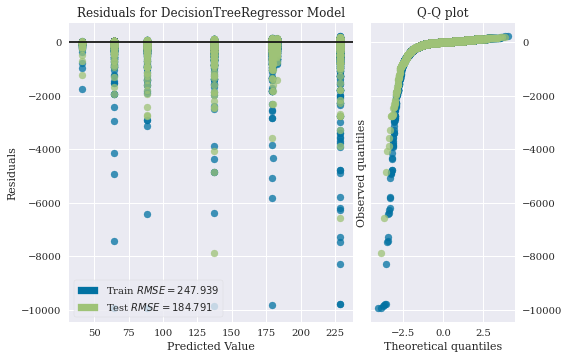

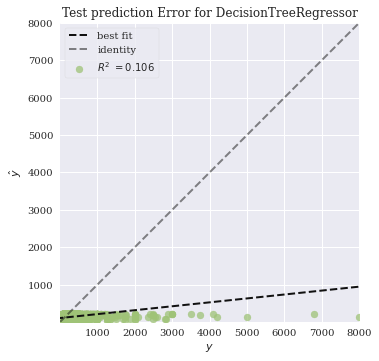

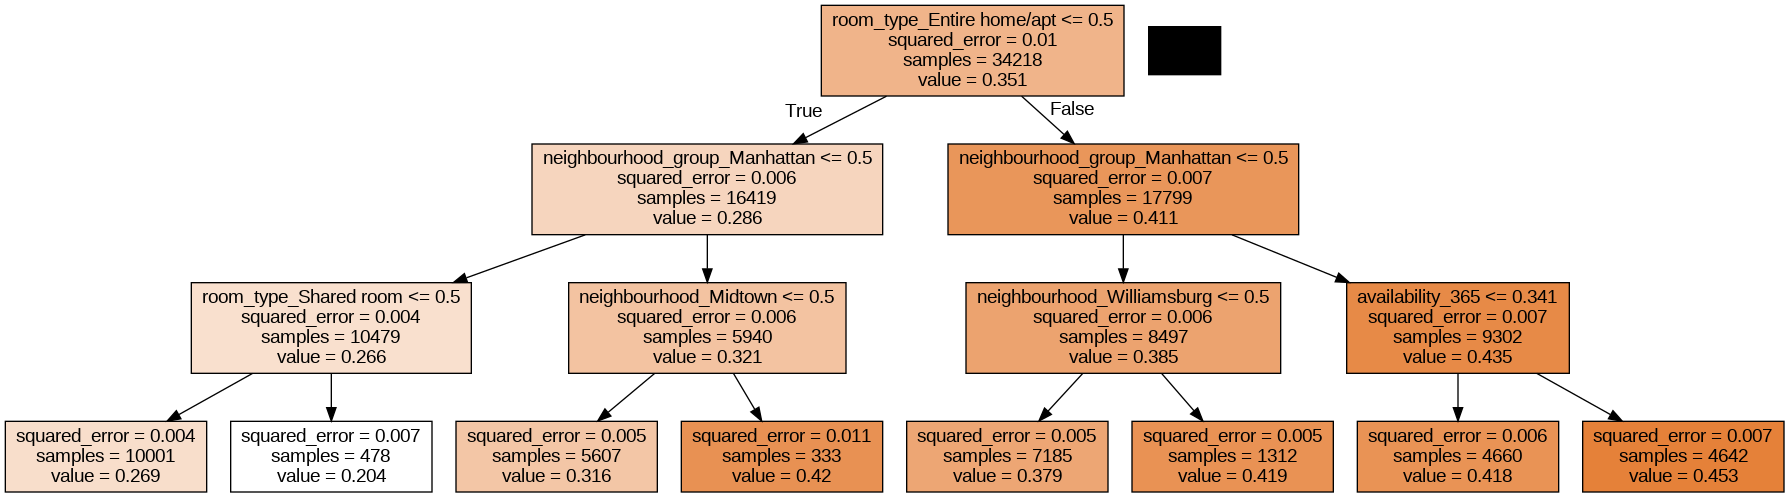

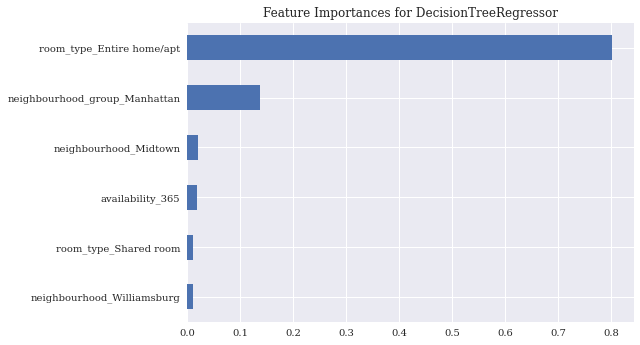

In [ ]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(random_state=42)
param_grid = {
    'max_depth': [2, 3],
    'min_samples_leaf': [0.001, 0.005, 0.01],
    'max_features': [0.25, 0.5, 0.75, 1]
}
best_reg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features)
best_reg.get_params()
create_tree_graph_png(best_reg, feature_names=features)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
     mean_rmse(scale)  std_rmse(scale)  max_depth  max_features  min_samples_leaf  min_samples_split
198          0.069144         0.002237       10.0          0.75             0.001               0.01
189          0.069448         0.002167       10.0          0.50             0.001               0.01
162          0.069808         0.002309        8.0          0.75             0.001               0.01
199          0.070255         0.002294       10.0          0.75             0.001               0.05
153          0.070312         0.002450        8.0          0.50             0.001               0.01
Worst 5 models leading to the minimum RMSE on scaled testing set: 
     mean_rmse(scale)  std_rmse(scale)  max_depth  max_features  min_samples_leaf  min_samples_split
35           0.100329         0.001561        2.0           1.0              0.05               

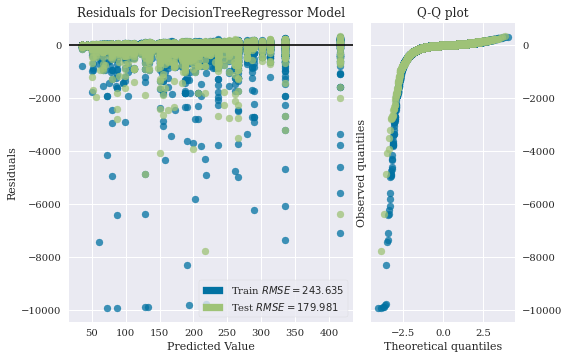

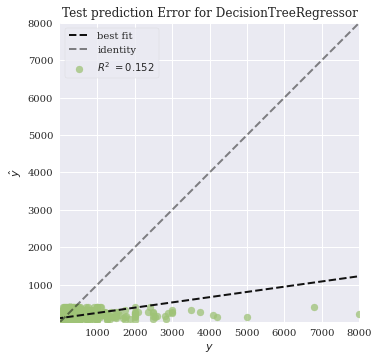

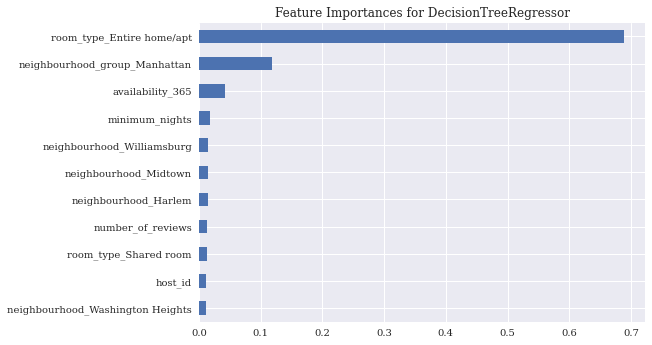

In [ ]:
reg = DecisionTreeRegressor(random_state=42)

"""
lot of hyperparameter tuning, the performance will usually be slightly
worse than what you measured using cross-validation (because your system ends up
fine-tuned to perform well on the validation data and will likely not perform as well
on unknown datasets)
"""

param_grid = {
    'max_depth': [2, 3, 4, 6, 8, 10],
    'min_samples_leaf': [0.001, 0.01, 0.05],
    'min_samples_split': [0.01, 0.05, 0.1],
    'max_features': [0.25, 0.5, 0.75, 1]
}

best_reg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
3           0.064938         0.002035          50.0         0.50          0.75
9           0.065039         0.002036          50.0         0.75          0.75
7           0.066453         0.002085         200.0         0.75          0.50
6           0.066713         0.002063         100.0         0.75          0.50
14          0.066978         0.002341          50.0         0.75          0.50
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
12          0.075818         0.001899         200.0         0.50          0.25
4           0.076544         0.001775          50.0         0.25          0.25
11          0.076550         0.001778         100.0         0.50          0.25
13          0.076577         0.001878         200.0         0.25          0.25

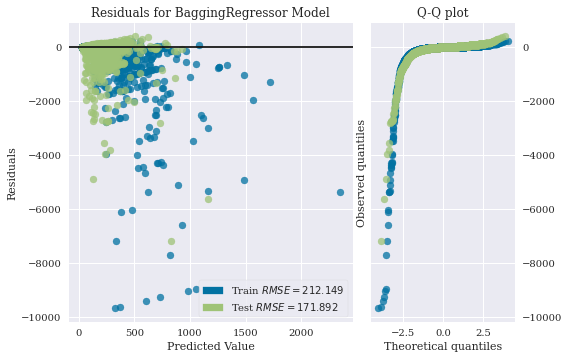

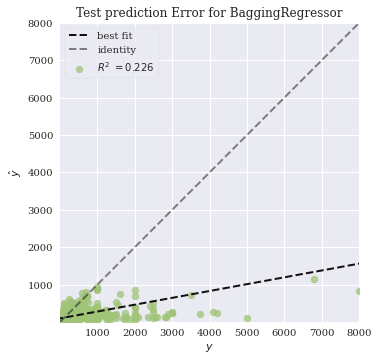

In [ ]:
reg = BaggingRegressor(DecisionTreeRegressor(random_state=42))

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [0.25, 0.5, 0.75],
    'max_samples': [0.25, 0.5, 0.75],
}


best_baggreg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)

In [ ]:
from itertools import product
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
import random

def set_model(model: str, params: dict):
    if model == 'bagging':
        model = BaggingRegressor(**params, bootstrap=True, oob_score=True,
                                 random_state=42)
    elif model == 'randomforest':
        model = RandomForestRegressor(**params, bootstrap=True, oob_score=True,
                                      random_state=42)
    elif model == 'extratrees':
        model = ExtraTreesRegressor(**params, bootstrap=True, oob_score=True,
                                    random_state=42)
    return model

def compute_hyperopt_oob(type_model: str, space_params: dict,
                     X_train, X_test, y_train, y_test, scaler_y, features, n_iter=None):
    """
    Combinations of all hyper parameters
    """
    params, values = zip(*space_params.items())
    product_params = list(product(*values))
    dict_param = dict(map(lambda i: (i, dict(zip(params, product_params[i]))),
                                    range(len(product_params))))
    
    """
    Defining max number of hyperoptimization trials
    """
    if n_iter is not None:
        random.seed(42)
        random_key = random.sample(list(dict_param), n_iter)
    else:
        random_key = list(range(len(product_params)))

    """
    Instantiate DF to save the results
    """
    results = pd.DataFrame(columns=['val_score'] + list(params),
                        index=range(len(dict_param)))
    best_val_rmse = np.inf
    best_params = None
    
    """
    Finding best hyperparameters over number of trials/combination
    Sorted accorded minimum validation rmse
    Saving values for each trial of hyperparameters set
    """
    for i, key in enumerate(random_key):
        params = dict_param[key]
        model = set_model(type_model, params)
        model.fit(X_train, y_train)
        val_rmse = np.sqrt(model.oob_score_)
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_params = params
        results.iloc[i] = [val_rmse] + list(params.values())
    results = results.sort_values('val_score')[:5]
    print('Top 5 models leading to the minimum RMSE on scaled testing set: ')
    print(results)

    """
    Evaluating the best model on testing set
    """
    best_reg = set_model(type_model, best_params)
    best_reg.fit(X_train, y_train)
    y_pred_train = best_reg.predict(X_train)
    y_pred_test = best_reg.predict(X_test)
    print_results(y_pred_train, y_pred_test, y_train, y_test, scaler_y, best_reg, features)
    return best_reg

Top 5 models leading to the minimum RMSE on scaled testing set: 
   val_score n_estimators max_features max_samples
2   0.656214           50         0.25        0.25
14  0.658544           50         0.25         0.5
10  0.659128           50         0.25        0.75
0   0.669117          200         0.25        0.75
1   0.741582           50          0.5        0.25


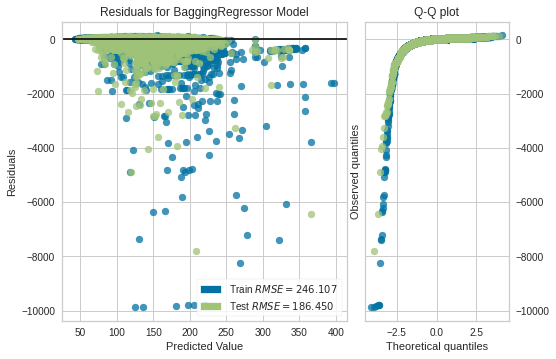

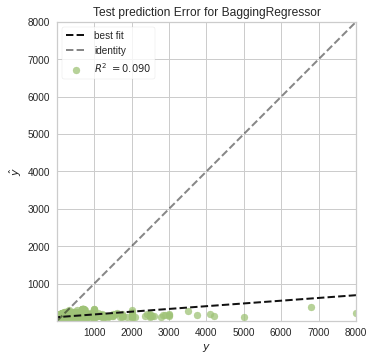

In [ ]:
best_baggreg_ = compute_hyperopt_oob('bagging', param_grid, X_train, X_test, y_train, y_test, scaler_y, features, n_iter=15)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
3           0.065142         0.001960          50.0         0.50          0.75
9           0.065457         0.002002          50.0         0.75          0.75
7           0.066134         0.002044         200.0         0.75          0.50
6           0.066582         0.002009         100.0         0.75          0.50
14          0.066672         0.001961          50.0         0.75          0.50
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
12          0.075288         0.001834         200.0         0.50          0.25
13          0.075974         0.001829         200.0         0.25          0.25
11          0.076151         0.001847         100.0         0.50          0.25
4           0.0

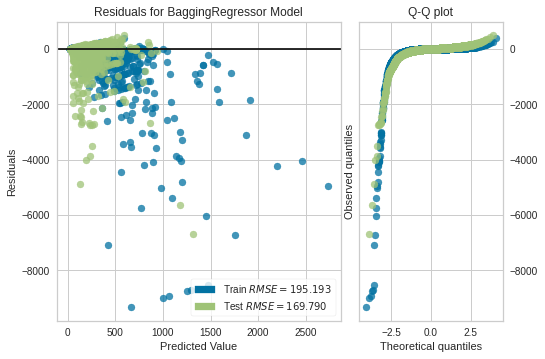

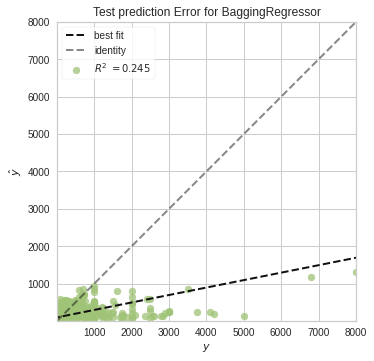

In [ ]:
reg = BaggingRegressor(bootstrap=False, random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [0.25, 0.5, 0.75],
    'max_samples': [0.25, 0.5, 0.75],
}

"""
Bootstrapping introduces a bit more diversity in the subsets that each predictor is
trained on, so bagging ends up with a slightly higher bias than pasting
but the extra diversity also means that the predictors end up being less correlated, so the ensemble’s
variance is reduced.
Overall, bagging often results in better models, which explains
why it is generally preferred.
"""

best_pastreg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
13          0.064412         0.002015         300.0         0.25          0.25
10          0.064487         0.002033         200.0         0.25          0.25
12          0.064500         0.001916         300.0         0.50          0.25
5           0.064524         0.001975         300.0         0.25          0.50
11          0.064569         0.001913         200.0         0.50          0.25
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  max_samples  max_features
3           0.065064         0.001884         100.0         0.50          0.75
7           0.065135         0.001835         300.0         0.75          0.50
6           0.065208         0.001804         200.0         0.75          0.50
14          0.0

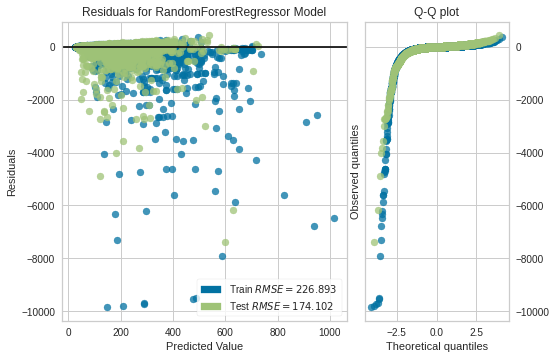

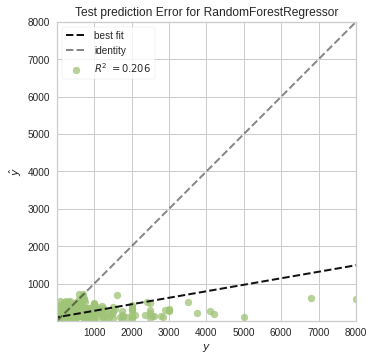

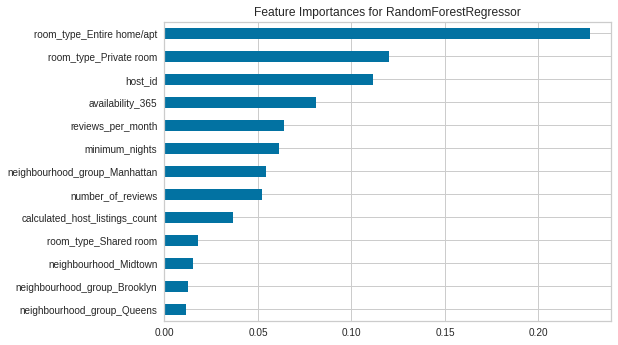

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [0.25, 0.5, 0.75],
    'max_samples': [0.25, 0.5, 0.75],
}

best_randreg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)

Top 5 models leading to the minimum RMSE on scaled testing set: 
   val_score n_estimators max_features max_samples
4   0.761572          100         0.75        0.75
9   0.764121          200         0.75        0.75
10  0.764671          100         0.25        0.75
13  0.765969          200          0.5        0.75
5     0.7662          100         0.75         0.5


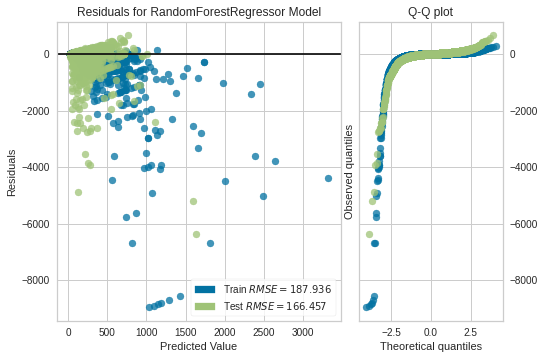

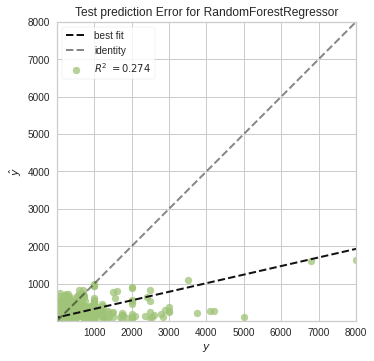

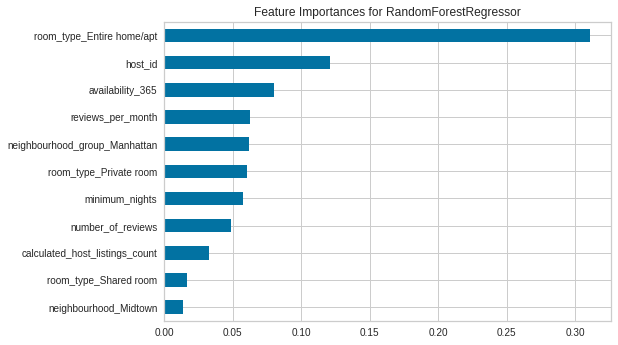

In [ ]:
best_randreg_=compute_hyperopt_oob('randomforest', param_grid, X_train, X_test, y_train, y_test, scaler_y, features, n_iter=15)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  min_samples_split  max_samples  max_features  max_depth
12          0.069868         0.002293         200.0               0.01         0.50          0.75        6.0
8           0.070712         0.002222         300.0               0.05         0.75          0.25        8.0
4           0.071164         0.002176         100.0               0.01         0.75          0.25        6.0
11          0.071367         0.002199         300.0               0.01         0.25          0.25        6.0
9           0.071861         0.002281         100.0               0.01         0.50          0.75        4.0
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  min_samples_split  max_samples  max_features  max_depth
0           0.073128         0.002296     

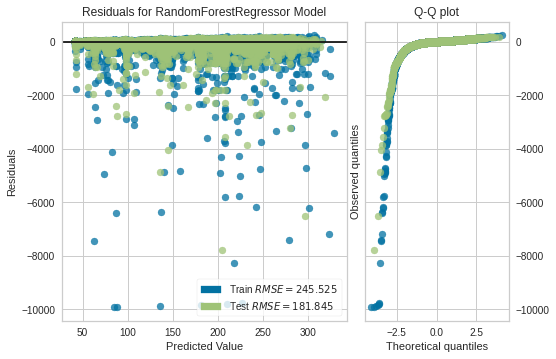

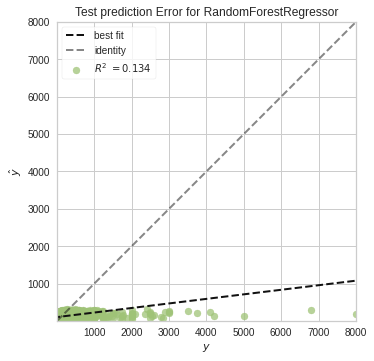

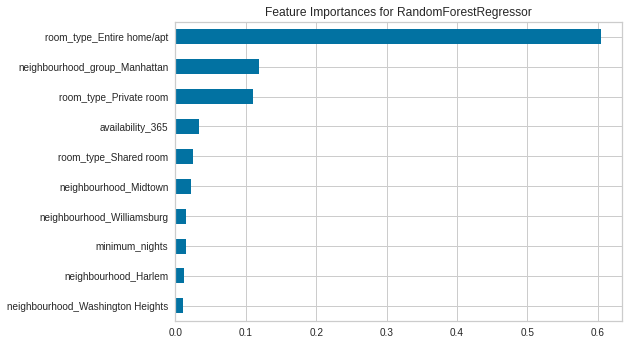

In [ ]:
param_grid = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_split': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_features': [0.25, 0.5, 0.75],
    'max_samples': [0.25, 0.5, 0.75],
}

best_randreg__=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
   mean_rmse(scale)  std_rmse(scale)  max_features  n_estimators
2          0.067291         0.001768          0.25         300.0
1          0.067334         0.001776          0.25         200.0
0          0.067482         0.001779          0.25         100.0
5          0.067844         0.001645          0.50         300.0
4          0.067886         0.001623          0.50         200.0
Worst 5 models leading to the minimum RMSE on scaled testing set: 
   mean_rmse(scale)  std_rmse(scale)  max_features  n_estimators
4          0.067886         0.001623          0.50         200.0
3          0.067998         0.001648          0.50         100.0
8          0.068333         0.001630          0.75         300.0
7          0.068385         0.001641          0.75         200.0
6          0.068529         0.001646          0.75         100.0


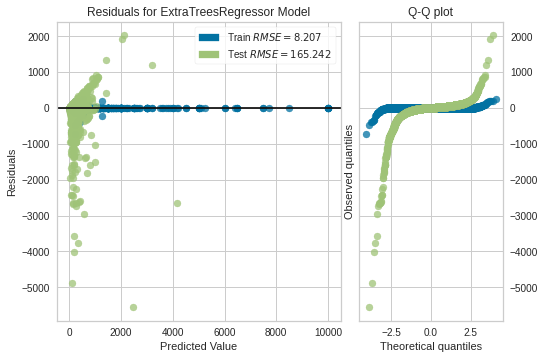

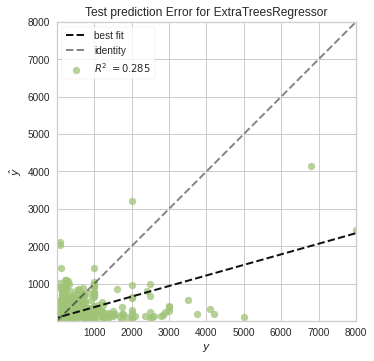

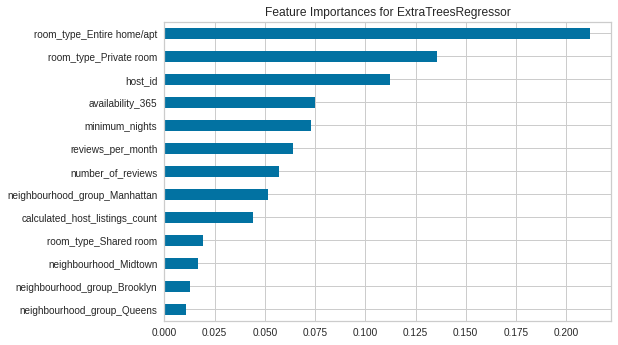

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [0.25, 0.5, 0.75],
}
reg = ExtraTreesRegressor(random_state=42)
best_extrareg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features)

Top 5 models leading to the minimum RMSE on scaled testing set: 
  val_score n_estimators max_features
2  0.756818          100         0.75
1  0.757596          100          0.5
0   0.75918          100         0.25
5   0.75986          200         0.75
4  0.760733          200          0.5


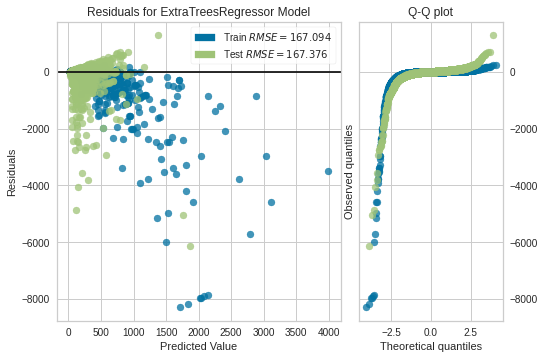

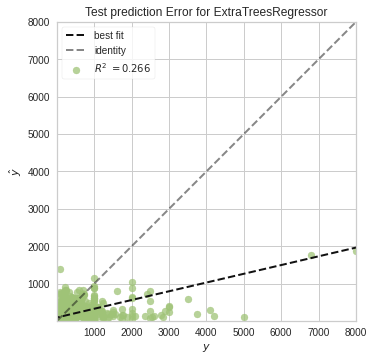

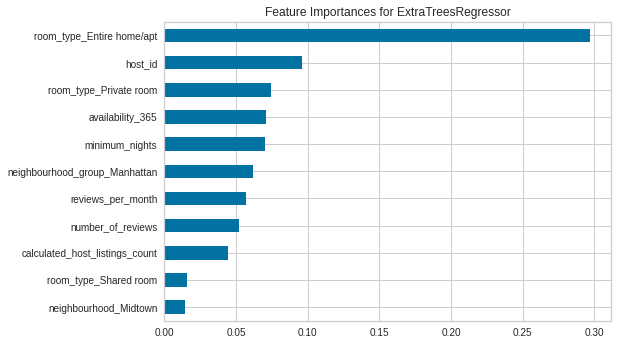

In [ ]:
best_extrareg_=compute_hyperopt_oob('extratrees', param_grid, X_train, X_test, y_train, y_test, scaler_y, features)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
   mean_rmse(scale)  std_rmse(scale)  learning_rate  n_estimators
2          0.073483         0.002207          0.001         300.0
1          0.073486         0.002201          0.001         200.0
0          0.073487         0.002201          0.001         100.0
3          0.073650         0.002281          0.010         100.0
5          0.074078         0.002166          0.010         300.0
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  learning_rate  n_estimators
7           0.087501         0.003211            0.1         200.0
8           0.088470         0.004701            0.1         300.0
9           0.092614         0.005481            1.0         100.0
10          0.092614         0.005481            1.0         200.0
11          0.092614         0.005481            1.0         300.0


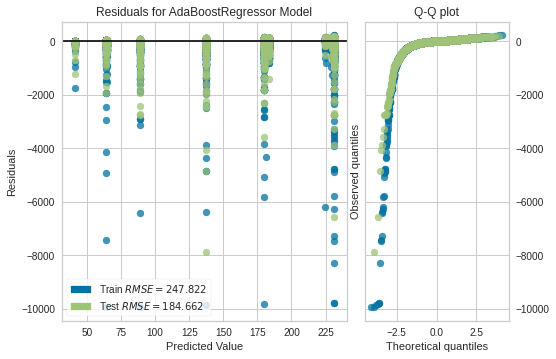

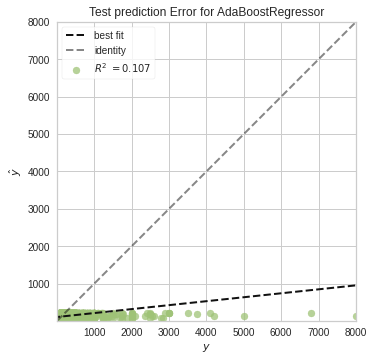

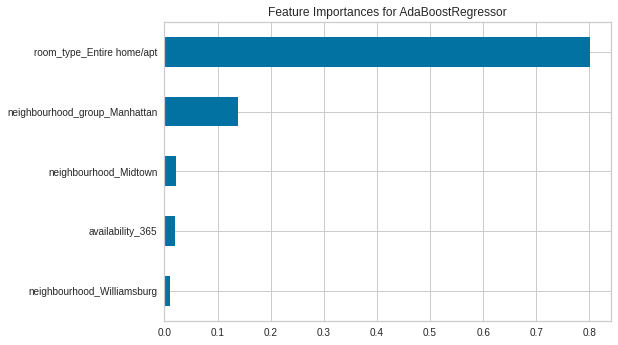

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}
reg = AdaBoostRegressor(random_state=42)
best_adareg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  n_estimators  learning_rate  base_estimator__min_samples_split  base_estimator__max_depth
6           0.070911         0.002280         100.0          0.001                               0.10                        8.0
13          0.070914         0.002276         200.0          0.001                               0.10                        8.0
3           0.071254         0.002284         200.0          0.001                               0.10                        6.0
14          0.071482         0.002285         200.0          0.010                               0.10                        6.0
10          0.072404         0.002243         100.0          0.010                               0.05                        4.0
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(

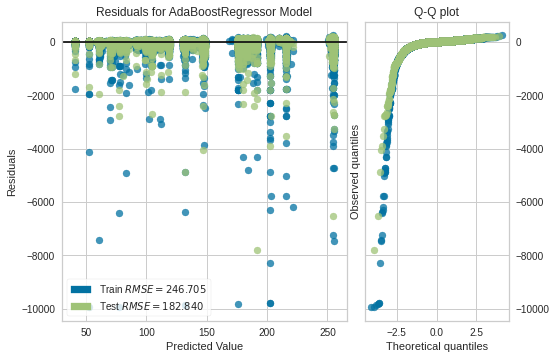

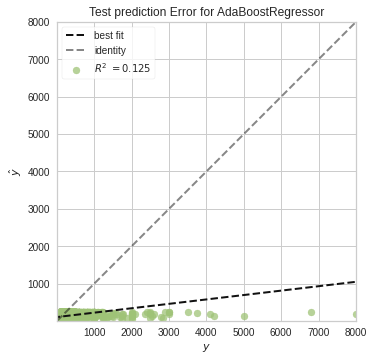

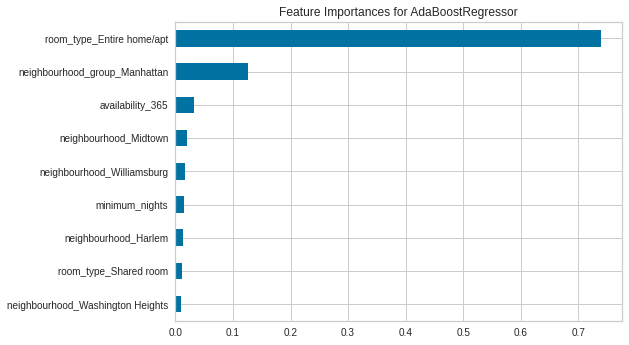

In [ ]:
param_grid = {
    'base_estimator__max_depth': [2, 4, 6, 8],
    'base_estimator__min_samples_split': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}
reg = AdaBoostRegressor(DecisionTreeRegressor(random_state=42), random_state=42)
best_adareg_=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  learning_rate  n_estimators
8           0.065318         0.002080            0.1         300.0
7           0.065781         0.002126            0.1         200.0
6           0.066893         0.002144            0.1         100.0
9           0.067021         0.002032            1.0         100.0
10          0.068216         0.001850            1.0         200.0
Worst 5 models leading to the minimum RMSE on scaled testing set: 
   mean_rmse(scale)  std_rmse(scale)  learning_rate  n_estimators
4          0.072504         0.002157          0.010         200.0
3          0.077453         0.001975          0.010         100.0
2          0.089862         0.001643          0.001         300.0
1          0.093106         0.001590          0.001         200.0
0          0.096916         0.001540          0.001         100.0


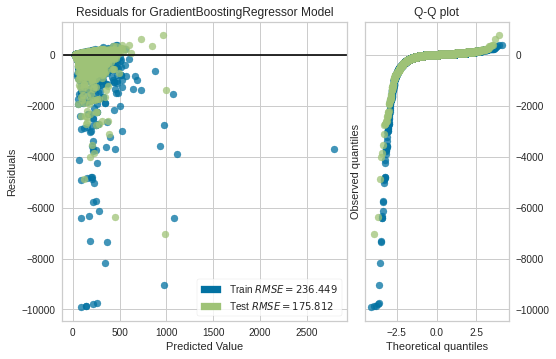

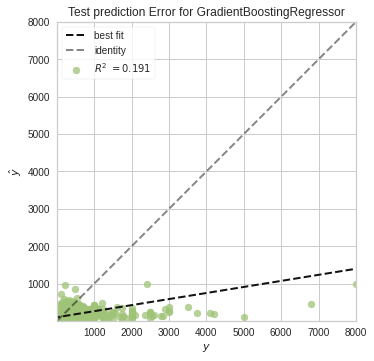

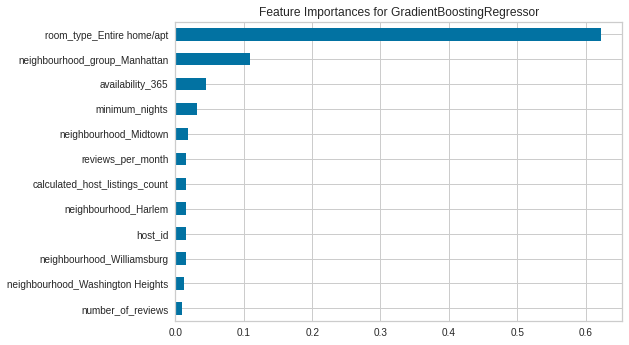

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}
reg = GradientBoostingRegressor(random_state=42)
best_gradreg=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features)

Fitting 10 folds for each of 15 candidates, totalling 150 fits
Top 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  subsample  n_estimators  min_samples_split  max_depth  learning_rate
5           0.064439         0.002006       0.75         200.0               0.01        6.0           0.10
8           0.066552         0.002024       0.25         300.0               0.01        8.0           0.01
13          0.067451         0.002384       0.50         100.0               0.05        3.0           1.00
4           0.069464         0.002315       0.75         200.0               0.05        6.0           1.00
0           0.069726         0.001904       0.50         100.0               0.10        8.0           1.00
Worst 5 models leading to the minimum RMSE on scaled testing set: 
    mean_rmse(scale)  std_rmse(scale)  subsample  n_estimators  min_samples_split  max_depth  learning_rate
10          0.078756         0.001986       0.25 

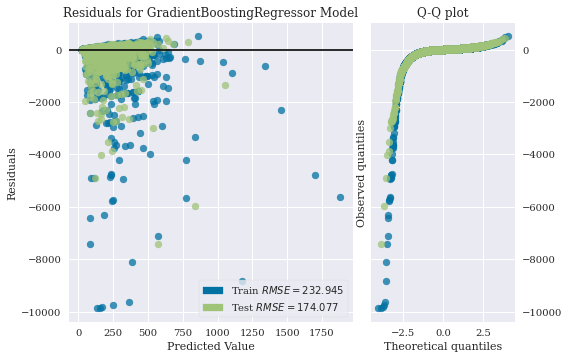

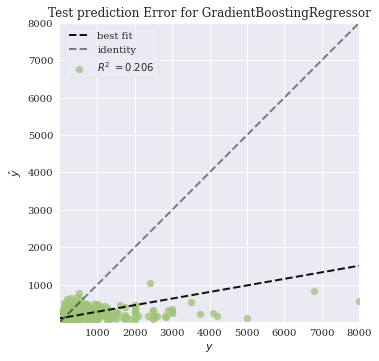

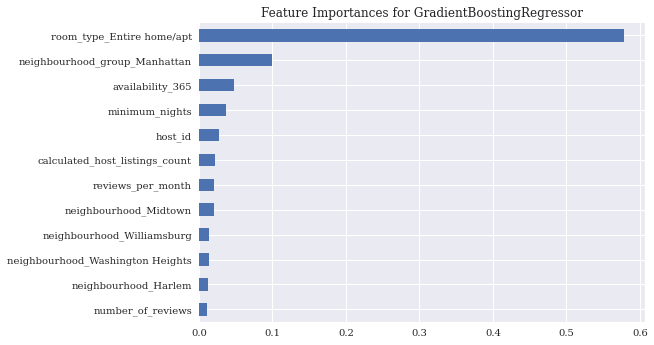

In [ ]:
param_grid = {
    'max_depth': [3, 4, 6, 8],
    'min_samples_split': [0.01, 0.05, 0.1],
    'subsample': [0.25, 0.5, 0.75],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}
reg = GradientBoostingRegressor(random_state=42)
best_gradreg_=main_gridsearch(reg, param_grid, X_train, y_train, X_test, y_test, scaler_y, features, n_iter=15)


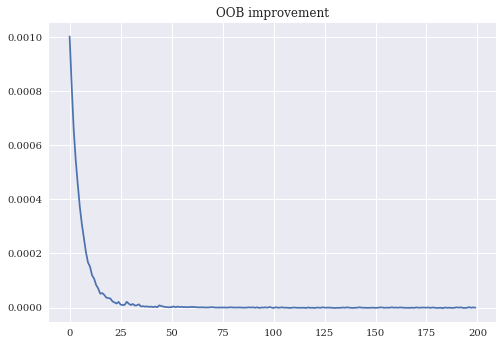

In [ ]:
pd.Series(best_gradreg_.oob_improvement_).plot(title='OOB improvement')